# Comprehensive LangGraph Tutorial: Build Intelligent AI Agents

Welcome to this comprehensive tutorial on LangGraph! In this notebook, you'll learn how to build increasingly sophisticated AI agents, from a basic chatbot to advanced agents with tools, memory, and complex workflows.

## What You'll Learn

This tutorial is divided into three comprehensive chapters:

1. **Chapter 1: Build a Basic Chatbot** - Learn the fundamentals of LangGraph by creating a simple conversational agent
2. **Chapter 2: Add Tools** - Extend your chatbot with web search capabilities using Tavily
3. **Chapter 3: Advanced State Management** - Build a sophisticated agent with custom tools and state tracking

By the end of this tutorial, you'll understand:
- How to create and manage state graphs
- How to add nodes and edges to control agent flow
- How to integrate external tools
- How to implement conditional logic
- How to track and manage complex state

Let's get started! 🚀

## Setup and Installation

First, let's install all the required packages. We'll need:
- `langgraph`: The core library for building stateful agents
- `langsmith`: For tracing and debugging (optional but highly recommended)
- `langchain-openai`: For OpenAI integration
- `langchain-anthropic`: For Anthropic integration (alternative)
- `langchain-tavily`: For web search capabilities
- `langchain-core`: Core utilities

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai langchain-anthropic langchain-tavily langchain-core langchain-community

### Configure API Keys

Now let's set up your API keys. This secure approach ensures your keys aren't hardcoded in the notebook.

You'll need:
- An **OpenAI API key** (get one at https://platform.openai.com/api-keys)
- A **LangSmith API key** (optional, get one at https://smith.langchain.com)
- A **Tavily API key** for Chapter 2 (get one at https://tavily.com)

In [2]:
import getpass
import os

def _set_env(var: str):
    """Helper function to securely set environment variables"""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set OpenAI API key
_set_env("OPENAI_API_KEY")

### Optional: Enable LangSmith Tracing

LangSmith is a powerful tool for debugging and monitoring your LangGraph applications. It lets you:
- Visualize the execution flow of your agents
- Debug issues by examining traces
- Monitor performance and token usage
- Test and evaluate your agents

If you have a LangSmith account, run the cell below to enable tracing:

In [3]:
# Optional: Enable LangSmith tracing
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Comprehensive Tutorial"

---
# Chapter 1: Build a Basic Chatbot

In this chapter, you'll build your first LangGraph agent - a simple chatbot that can hold conversations. This will introduce you to the core concepts of LangGraph.

## Key Concepts

### 1. State
State is the information that flows through your graph. It's defined as a TypedDict and can contain any data your agent needs. In our case, we'll track messages.

### 2. StateGraph
A StateGraph is a state machine that defines how your agent processes information. It consists of:
- **Nodes**: Units of work (functions that process the state)
- **Edges**: Connections between nodes that define the flow

### 3. Reducers
Reducers control how state updates are applied. The `add_messages` reducer appends new messages instead of overwriting them.

Let's build our chatbot step by step!

## Step 1: Define the State

First, we need to define what information our chatbot will track. For a basic chatbot, we'll track a list of messages.

Notice the `add_messages` annotation - this tells LangGraph to append new messages to the list rather than replacing the entire list.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    The State of our chatbot.

    Attributes:
        messages: A list of messages in the conversation.
                  The add_messages reducer appends new messages instead of overwriting.
    """
    messages: Annotated[list, add_messages]
    test: str

print("✓ State defined successfully!")
print("\nOur state tracks:")
print("  - messages: list of conversation messages (with add_messages reducer)")

✓ State defined successfully!

Our state tracks:
  - messages: list of conversation messages (with add_messages reducer)


## Step 2: Create the StateGraph

Now we'll create a StateGraph object. This is the foundation of our chatbot - it defines the structure of our agent as a state machine.

In [4]:
# Create the graph builder
graph_builder = StateGraph(State)

print("✓ StateGraph created!")
print("\nThe graph builder is ready to:")
print("  1. Accept nodes (units of work)")
print("  2. Connect nodes with edges (define the flow)")
print("  3. Compile into a runnable graph")

✓ StateGraph created!

The graph builder is ready to:
  1. Accept nodes (units of work)
  2. Connect nodes with edges (define the flow)
  3. Compile into a runnable graph


## Step 3: Initialize the Language Model

We'll use OpenAI's GPT-4 for our chatbot. The `init_chat_model` function provides a unified interface for different LLM providers.

In [5]:
from langchain.chat_models import init_chat_model

# Initialize the language model
# You can also use "anthropic:claude-3-5-sonnet-latest" or other models
llm = init_chat_model("openai:gpt-5", temperature=0)

print("✓ Language model initialized!")
print(f"\nUsing model: GPT-4o")
print("Temperature: 0 (deterministic responses)")

✓ Language model initialized!

Using model: GPT-4o
Temperature: 0 (deterministic responses)


## Step 4: Create the Chatbot Node

Nodes are functions that do the actual work. Our chatbot node will:
1. Receive the current state (with all messages)
2. Send the messages to the LLM
3. Return the LLM's response as a state update

Notice the pattern: the function receives `state` and returns a dictionary with updates to apply.

In [ ]:
def chatbot(state: State):
    """
    The chatbot node that processes messages.

    Args:
        state: The current state containing the message history

    Returns:
        A dictionary with the new message to add to the state
    """
    # Invoke the LLM with the current message history
    response = llm.invoke(state["messages"])

    # 1. First copy the state:
    # state_copy_test = state['test']
    # 2. Then update the copy:#
    # new_state_test = state_copy_test + ' test'
    #
    # Return the response as a state update
    # The add_messages reducer will append this to the message list
    #  3. Then return the updated copy:
    return {"messages": [response]} #'test': new_state_test}

# Add the node to our graph
# First argument: unique node name
# Second argument: the function to call
graph_builder.add_node("chatbot", chatbot)

print("✓ Chatbot node created and added to graph!")
print("\nNode function:")
print("  Input: Current state with message history")
print("  Process: Send messages to LLM")
print("  Output: LLM response as new message")

✓ Chatbot node created and added to graph!

Node function:
  Input: Current state with message history
  Process: Send messages to LLM
  Output: LLM response as new message


## Step 5: Define the Flow with Edges

Now we need to tell the graph:
1. Where to start (entry point)
2. Where to end (exit point)

Edges connect nodes and define the execution flow.

In [7]:
# Define the entry point: start at the chatbot node
graph_builder.add_edge(START, "chatbot")

# Define the exit point: end after the chatbot responds
graph_builder.add_edge("chatbot", END)

print("✓ Graph flow defined!")
print("\nExecution flow:")
print("  START → chatbot → END")
print("\nThis creates a simple linear flow where:")
print("  1. Execution starts")
print("  2. Chatbot processes the input")
print("  3. Execution ends")

✓ Graph flow defined!

Execution flow:
  START → chatbot → END

This creates a simple linear flow where:
  1. Execution starts
  2. Chatbot processes the input
  3. Execution ends


## Step 6: Compile the Graph

Before we can use our graph, we need to compile it. This creates a `CompiledGraph` that we can invoke.

In [8]:
# Compile the graph into a runnable object
graph = graph_builder.compile()

print("✓ Graph compiled successfully!")
print("\nThe graph is now ready to use!")
print("You can:")
print("  - invoke() for single responses")
print("  - stream() for streaming responses")
print("  - visualize it with draw_mermaid_png()")

✓ Graph compiled successfully!

The graph is now ready to use!
You can:
  - invoke() for single responses
  - stream() for streaming responses
  - visualize it with draw_mermaid_png()


## Step 7: Visualize the Graph (Optional)

LangGraph allows you to visualize your agent's structure. This is incredibly helpful for understanding and debugging complex workflows.

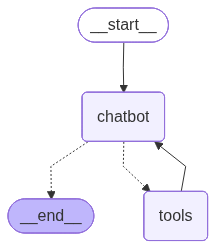


✓ Graph visualization displayed above!


In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("\n✓ Graph visualization displayed above!")
except Exception as e:
    print(f"Could not display graph visualization: {e}")
    print("This is optional and requires additional dependencies.")

## Step 8: Test the Chatbot

Now let's test our chatbot! We'll create a simple streaming function that displays the chatbot's responses.

In [ ]:
def stream_graph_updates(user_input: str):
    """
    Stream graph updates and display the chatbot's response.

    Args:
        user_input: The user's message
    """
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# Test with a simple message
print("Testing the chatbot with: 'What is LangGraph?'\n")
stream_graph_updates("What is LangGraph?")

Testing the chatbot with: 'What is LangGraph?'

Assistant: LangGraph is an open‑source library (Python and JavaScript) from LangChain for building stateful, multi‑step AI agents and workflows as graphs/state machines. It’s designed for agentic apps that need loops, memory, tool use, and human‑in‑the‑loop control—capabilities that go beyond simple DAG pipelines.

Key ideas
- State: A typed, shared state object (with merge/reducer semantics) that persists across steps.
- Nodes: Functions/LLM calls/tools/subgraphs that read/update state.
- Edges: Deterministic or conditional transitions between nodes; supports cycles (loops) and branching.
- Persistence: Built‑in checkpointing so you can pause/resume, recover from errors, and maintain per‑session memory (e.g., SQLite, Postgres, Redis, LangSmith).
- Streaming and events: Stream state deltas/tokens and observe fine‑grained events.
- Interrupts: Add breakpoints for human approval or external input mid‑run.
- Multi‑agent patterns: Compose pla

## Interactive Chat Loop

Now let's create an interactive chat loop so you can have a real conversation with your chatbot!

**Tip:** Type 'quit', 'exit', or 'q' to exit the chat.

In [ ]:
print("=" * 50)
print("Interactive Chatbot - Chapter 1")
print("=" * 50)
print("Type 'quit', 'exit', or 'q' to exit\n")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
        print()  # Add a blank line for readability
    except KeyboardInterrupt:
        print("\nGoodbye!")
        break
    except Exception as e:
        print(f"An error occurred: {e}")
        break

Interactive Chatbot - Chapter 1
Type 'quit', 'exit', or 'q' to exit



Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=701c23c2-a54f-41b9-9d19-d43c45394a3d,id=db236d80-0205-45fd-810f-b88e4991b59e; trace=701c23c2-a54f-41b9-9d19-d43c45394a3d,id=ccf7c089-4f3a-4080-8e4c-e9858adcaff8; trace=701c23c2-a54f-41b9-9d19-d43c45394a3d,id=701c23c2-a54f-41b9-9d19-d43c45394a3d
Failed to send compressed multipart ingest: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=96eb84b4-64f9-4fee-8b96-af5caefb3841,id=96eb84b4-64f9-4fee-8b96-af5caefb3841; trace=96eb84b4-64f9-4fee-8b96-af5caefb3841,id=1eb2d3fc-a3b8-42c4-bf5b-fc2fa5bee48d; trace=96eb84b4-

Assistant: It looks like your message didn’t come through. How can I help today?

If it helps, you can tell me:
- What you’re trying to do (e.g., explain a concept, draft an email, fix code, plan a trip)
- Any text or data to work with (paste it here)
- Goals, audience, tone, and length
- Deadlines or constraints (tools, format, word count)

Feel free to paste the content or describe the task, and I’ll jump in.



## Chapter 1 Summary

Congratulations! You've built your first LangGraph agent! 🎉

### What You Learned:

1. **State Management**: How to define state with TypedDict and use reducers
2. **StateGraph**: How to create a state machine for your agent
3. **Nodes**: How to define units of work as functions
4. **Edges**: How to control the flow of execution
5. **Compilation**: How to compile and run your graph

### Limitations:

Our current chatbot has some limitations:
- It can only answer from its training data
- It can't search the web for current information
- It doesn't remember conversations between runs

In the next chapter, we'll address the first limitation by adding web search capabilities! 🔍

---
# Chapter 2: Add Tools to Your Chatbot

In this chapter, we'll enhance our chatbot by adding tool-calling capabilities. Specifically, we'll integrate web search so the chatbot can find current information.

## Key Concepts

### 1. Tool Calling
Modern LLMs can decide when to use tools. They output structured tool calls that we can execute and feed the results back to the LLM.

### 2. Conditional Edges
Unlike fixed edges, conditional edges use functions to decide where to route the execution based on the current state.

### 3. Tool Node
A special node that executes tool calls made by the LLM.

### 4. Loops
Our graph will now have a loop: chatbot → tools → chatbot → END

Let's build it!

## Step 1: Set Up Tavily Search

Tavily is a search engine optimized for LLMs. Let's set up our API key and create a search tool.

In [10]:
# Set up Tavily API key
_set_env("TAVILY_API_KEY")

print("✓ Tavily API key configured!")

✓ Tavily API key configured!


## Step 2: Define the Search Tool

We'll create a TavilySearch tool that can search the web. The `max_results=2` parameter limits the number of results to keep responses concise.

In [11]:
from langchain_tavily import TavilySearch

# Create the search tool
tool = TavilySearch(max_results=2)
tools = [tool]

print("✓ Tavily search tool created!")
print("\nTool capabilities:")
print(f"  - Name: {tool.name}")
print(f"  - Description: {tool.description}")
print("  - Max results: 2")

# Test the tool
print("\nTesting the tool with query: 'What is LangGraph?'")
result = tool.invoke("What is LangGraph?")
print(f"\nGot {len(result.get('results', []))} results!")
if result.get('results'):
    print(f"First result title: {result['results'][0]['title']}")

✓ Tavily search tool created!

Tool capabilities:
  - Name: tavily_search
  - Description: A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.
  - Max results: 2

Testing the tool with query: 'What is LangGraph?'

Got 2 results!
First result title: What is LangGraph?


## Step 3: Create the State and Graph

We'll use the same State definition as Chapter 1, but now we'll bind tools to the LLM.

In [12]:
# Reuse the State definition from Chapter 1
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Create a new graph builder
graph_builder = StateGraph(State)

# Bind tools to the LLM
# This tells the LLM about available tools and how to call them
llm_with_tools = llm.bind_tools(tools)

print("✓ State and graph builder created!")
print("✓ Tools bound to LLM!")
print("\nThe LLM can now:")
print("  - Decide when to use tools")
print("  - Format tool calls correctly")
print("  - Incorporate tool results into responses")

✓ State and graph builder created!
✓ Tools bound to LLM!

The LLM can now:
  - Decide when to use tools
  - Format tool calls correctly
  - Incorporate tool results into responses


## Step 4: Create the Enhanced Chatbot Node

Our chatbot node now uses the LLM with tools. The LLM can choose to:
1. Respond directly to the user
2. Call a tool to get more information first

In [ ]:
def chatbot(state: State):
    """
    Enhanced chatbot node that can call tools.

    The LLM will decide whether to:
    1. Respond directly to the user
    2. Call a tool to gather information first
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Add the chatbot node
graph_builder.add_node("chatbot", chatbot)

print("✓ Enhanced chatbot node added!")

✓ Enhanced chatbot node added!


## Step 5: Create the Tool Node

The tool node executes any tool calls made by the LLM. LangGraph provides a prebuilt `ToolNode` for this!

Here's what happens:
1. The LLM makes a tool call (structured output)
2. The tool node extracts the tool name and arguments
3. It executes the tool
4. It packages the result as a ToolMessage
5. The result goes back to the LLM

In [14]:
from langgraph.prebuilt import ToolNode

# Create a tool node using LangGraph's prebuilt ToolNode
tool_node = ToolNode(tools=tools)

# Add it to the graph
graph_builder.add_node("tools", tool_node)

print("✓ Tool node created and added!")
print("\nTool node will:")
print("  1. Extract tool calls from the LLM's response")
print("  2. Execute the requested tools")
print("  3. Format results as ToolMessages")
print("  4. Return results to be added to the state")

✓ Tool node created and added!

Tool node will:
  1. Extract tool calls from the LLM's response
  2. Execute the requested tools
  3. Format results as ToolMessages
  4. Return results to be added to the state


## Step 6: Define Conditional Routing

Now comes the interesting part! We need conditional logic to decide:
- If the LLM made tool calls → route to the tool node
- If the LLM responded directly → end the conversation

LangGraph provides a prebuilt `tools_condition` function for this!

In [15]:
from langgraph.prebuilt import tools_condition

# Add conditional edges from the chatbot
# The tools_condition function checks if tool calls were made
graph_builder.add_conditional_edges(
    "chatbot",  # Source node
    tools_condition,  # Condition function
)

# After tools are executed, always go back to the chatbot
# This allows the LLM to use tool results in its response
graph_builder.add_edge("tools", "chatbot")

# Define the entry point
graph_builder.add_edge(START, "chatbot")

print("✓ Conditional routing configured!")
print("\nExecution flow:")
print("  START → chatbot")
print("           ↓")
print("       [Decision]")
print("      ↙         ↘")
print("   tools        END")
print("     ↓")
print("  chatbot")
print("     ↓")
print("    END")

✓ Conditional routing configured!

Execution flow:
  START → chatbot
           ↓
       [Decision]
      ↙         ↘
   tools        END
     ↓
  chatbot
     ↓
    END


## Step 7: Compile and Visualize

Let's compile our enhanced graph and visualize it!

In [16]:
# Compile the graph
graph = graph_builder.compile()

print("✓ Enhanced graph compiled!")
print("\nThe graph now supports:")
print("  - Tool calling")
print("  - Conditional routing")
print("  - Loops (tool → chatbot → tool)")

# Visualize the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    print("\n✓ Graph visualization displayed above!")
    print("Notice the loop between 'chatbot' and 'tools'!")
except Exception as e:
    print(f"\nCould not display visualization: {e}")

✓ Enhanced graph compiled!

The graph now supports:
  - Tool calling
  - Conditional routing
  - Loops (tool → chatbot → tool)

Could not display visualization: name 'Image' is not defined


## Step 8: Test the Enhanced Chatbot

Let's test our chatbot with questions that require web search!

In [17]:
def stream_graph_updates(user_input: str):
    """Stream and display graph updates"""
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

# Test with a question requiring current information
print("Testing with: 'What are the latest features in LangGraph?'\n")
stream_graph_updates("What are the latest features in LangGraph?")

Testing with: 'What are the latest features in LangGraph?'

Assistant: 
Assistant: {"query": "LangGraph platform updates 2025", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://datahub.io/@donbr/langgraph-unleashed/agent-platform-ecosystem", "title": "Platform Ecosystem: LangGraph alternatives (May 2025)", "content": "The following diagram illustrates the current landscape of LangGraph alternatives, organized by platform type and updated with the latest 2025 developments:\n\n## 1. Open Source Frameworks (Updated)\n\n### 🆕 Google ADK (Agent Development Kit) [...] ## 2. Enterprise Cloud Platforms (2025 Updates)\n\n### 🔥 Azure AI Foundry Agent Service (GA)\n\n Launch: May 19, 2025 - General Availability\n Unified Experience: AutoGen + Semantic Kernel in single SDK\n Security: Microsoft Entra Agent ID for enterprise identity management\n Protocols: Native A2A and MCP support\n Observability: Built-in performance, quality, cost, and safety metrics\n Be

## Interactive Chat with Tools

Now let's chat with our enhanced bot! Try asking questions that require current information.

In [ ]:
print("=" * 50)
print("Interactive Chatbot with Tools - Chapter 2")
print("=" * 50)
print("The bot can now search the web for information!")
print("Type 'quit', 'exit', or 'q' to exit\n")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
        print()
    except KeyboardInterrupt:
        print("\nGoodbye!")
        break
    except Exception as e:
        print(f"An error occurred: {e}")
        break

## Chapter 2 Summary

Excellent work! You've now built a tool-augmented AI agent! 🎉

### What You Learned:

1. **Tool Integration**: How to add external tools to your agent
2. **Tool Binding**: How to tell the LLM about available tools
3. **Tool Nodes**: How to execute tool calls
4. **Conditional Edges**: How to add decision points to your graph
5. **Loops**: How to create iterative workflows

### Key Concepts:

- **Tool Calling**: The LLM decides when to use tools
- **Conditional Routing**: The graph flow depends on the LLM's decision
- **Tool Node**: Prebuilt node for executing tool calls
- **Loops**: The agent can use multiple tools before responding

### What's Next?

In Chapter 3, we'll build an even more sophisticated agent with:
- Custom mathematical tools
- Advanced state management
- State tracking (counting LLM calls)
- More complex workflows

Let's dive in! 🚀

---
# Chapter 3: Advanced State Management and Custom Tools

In this final chapter, we'll build a sophisticated agent that performs arithmetic operations. This will demonstrate:
- Creating custom tools with the `@tool` decorator
- Advanced state management (tracking multiple state keys)
- Manual tool execution (building our own tool node)
- Complex conditional logic

## The Agent We'll Build

Our agent will:
1. Accept arithmetic problems
2. Use tools to perform calculations (add, multiply, divide)
3. Track how many times the LLM is called
4. Show the full reasoning process

## Key Concepts

### 1. Custom Tools
We'll create our own tools using the `@tool` decorator

### 2. Extended State
Our state will track both messages and LLM call count

### 3. Custom Tool Node
We'll build our own tool execution logic

### 4. Advanced Routing
Custom routing function to decide the next step

Let's build it!

## Step 1: Define Custom Tools

We'll create three mathematical tools. Notice how we use the `@tool` decorator and provide detailed docstrings - these help the LLM understand when and how to use each tool.

In [18]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# Collect tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}

print("✓ Custom tools created!\n")
print("Available tools:")
for tool in tools:
    print(f"  - {tool.name}: {tool.description}")

# Test the tools
print("\nTesting tools:")
print(f"  add(3, 4) = {add.invoke({'a': 3, 'b': 4})}")
print(f"  multiply(3, 4) = {multiply.invoke({'a': 3, 'b': 4})}")
print(f"  divide(12, 3) = {divide.invoke({'a': 12, 'b': 3})}")

✓ Custom tools created!

Available tools:
  - add: Adds a and b.

    Args:
        a: first int
        b: second int
  - multiply: Multiply a and b.

    Args:
        a: first int
        b: second int
  - divide: Divide a by b.

    Args:
        a: first int
        b: second int

Testing tools:
  add(3, 4) = 7
  multiply(3, 4) = 12
  divide(12, 3) = 4.0


## Step 2: Set Up the Language Model

We'll use Anthropic's Claude for this example. Claude is excellent at tool calling and mathematical reasoning.

In [19]:
# Set Anthropic API key if needed
_set_env("ANTHROPIC_API_KEY")

# Initialize Claude
llm = init_chat_model(
    "anthropic:claude-3-7-sonnet-latest",
    temperature=0
)

# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

print("✓ Language model initialized!")
print("\nModel: Claude 3.7 Sonnet")
print("Temperature: 0 (deterministic)")
print(f"Tools bound: {len(tools)}")

✓ Language model initialized!

Model: Claude 3.7 Sonnet
Temperature: 0 (deterministic)
Tools bound: 3


## Step 3: Define Advanced State

Our state now tracks two things:
1. **messages**: The conversation history (with `add` reducer)
2. **llm_calls**: A counter for how many times we call the LLM

Notice that `llm_calls` doesn't have a reducer, so it will be overwritten each time.

In [ ]:
from langchain_core.messages import AnyMessage
import operator

class MessagesState(TypedDict):
    """
    Advanced state with multiple keys.

    Attributes:
        messages: List of conversation messages (with add reducer)
        llm_calls: Counter for LLM invocations (no reducer - gets replaced)
    """
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

print("✓ Advanced state defined!\n")
print("State keys:")
print("  - messages: list[AnyMessage] (with operator.add reducer)")
print("  - llm_calls: int (no reducer - will be replaced)")
print("\nThe add reducer will append messages to the list.")
print("The llm_calls will be replaced with each update.")

✓ Advanced state defined!

State keys:
  - messages: list[AnyMessage] (with operator.add reducer)
  - llm_calls: int (no reducer - will be replaced)

The add reducer will append messages to the list.
The llm_calls will be replaced with each update.


## Step 4: Create the LLM Node

Our LLM node now:
1. Adds a system message to guide the LLM's behavior
2. Calls the LLM with the conversation history
3. Increments the LLM call counter

In [ ]:
from langchain_core.messages import SystemMessage

def llm_call(state: dict):
    """
    LLM node that decides whether to call a tool or respond.

    This node:
    1. Adds a system message to guide the LLM
    2. Invokes the LLM with conversation history
    3. Tracks the number of LLM calls

    Args:
        state: Current state with messages and llm_calls counter

    Returns:
        State update with new message and incremented counter
    """
    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

print("✓ LLM node created!\n")
print("Node behavior:")
print("  1. Adds system message to guide the LLM")
print("  2. Sends conversation to LLM with tools")
print("  3. Increments llm_calls counter")
print("  4. Returns LLM response (may include tool calls)")

✓ LLM node created!

Node behavior:
  1. Adds system message to guide the LLM
  2. Sends conversation to LLM with tools
  3. Increments llm_calls counter
  4. Returns LLM response (may include tool calls)


## Step 5: Create Custom Tool Node

Instead of using the prebuilt ToolNode, we'll build our own to see how it works under the hood.

This node:
1. Extracts tool calls from the last message
2. Executes each tool call
3. Packages results as ToolMessages

In [ ]:
from langchain_core.messages import ToolMessage

def tool_node(state: dict):
    """
    Custom tool node that executes tool calls.

    This shows how to manually implement tool execution:
    1. Extract tool calls from the last AI message
    2. Look up and invoke each tool
    3. Format results as ToolMessages

    Args:
        state: Current state with messages

    Returns:
        State update with tool result messages
    """
    # Get the last message (should contain tool calls)
    if messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError("No message found in input")

    # Execute each tool call
    outputs = []
    for tool_call in message.tool_calls:
        # Look up the tool by name
        tool = tools_by_name[tool_call["name"]]

        # Invoke the tool with the provided arguments
        observation = tool.invoke(tool_call["args"])

        # Create a ToolMessage with the result
        outputs.append(
            ToolMessage(
                content=str(observation),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outputs}

print("✓ Custom tool node created!\n")
print("Tool node process:")
print("  1. Extract tool calls from last message")
print("  2. For each tool call:")
print("     a. Look up the tool by name")
print("     b. Invoke with provided arguments")
print("     c. Wrap result in ToolMessage")
print("  3. Return all tool results")

✓ Custom tool node created!

Tool node process:
  1. Extract tool calls from last message
  2. For each tool call:
     a. Look up the tool by name
     b. Invoke with provided arguments
     c. Wrap result in ToolMessage
  3. Return all tool results


## Step 6: Define Conditional Routing

We need a function to decide what to do after the LLM responds:
- If it made tool calls → go to tool_node
- If it responded directly → END

In [ ]:
from typing import Literal

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """
    Conditional routing function.

    Decides whether to:
    - Continue to tool_node (if LLM made tool calls)
    - End execution (if LLM provided a final answer)

    Args:
        state: Current state with messages

    Returns:
        "tool_node" if tools should be called, END otherwise
    """
    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, perform the action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

print("✓ Routing function defined!\n")
print("Routing logic:")
print("  - If last message has tool_calls → route to 'tool_node'")
print("  - Otherwise → route to END")
print("\nThis allows the agent to:")
print("  1. Call multiple tools if needed")
print("  2. Loop back to think after tool results")
print("  3. End when ready to respond to user")

✓ Routing function defined!

Routing logic:
  - If last message has tool_calls → route to 'tool_node'
  - Otherwise → route to END

This allows the agent to:
  1. Call multiple tools if needed
  2. Loop back to think after tool results
  3. End when ready to respond to user


## Step 7: Build the Complete Agent

Now let's assemble all the pieces into a complete agent!

In [ ]:
# Create the graph builder
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call) # type: ignore
agent_builder.add_node("tool_node", tool_node) # type: ignore

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

print("✓ Agent built and compiled!\n")
print("Agent structure:")
print("  Nodes:")
print("    - llm_call: Reasons about the problem")
print("    - tool_node: Executes calculations")
print("\n  Flow:")
print("    START → llm_call → [decision]")
print("                          ↓         ↘")
print("                      tool_node     END")
print("                          ↓")
print("                      llm_call → ...")

✓ Agent built and compiled!

Agent structure:
  Nodes:
    - llm_call: Reasons about the problem
    - tool_node: Executes calculations

  Flow:
    START → llm_call → [decision]
                          ↓         ↘
                      tool_node     END
                          ↓
                      llm_call → ...


## Step 8: Visualize the Agent

Let's see the structure of our agent! Notice the loop and conditional routing.

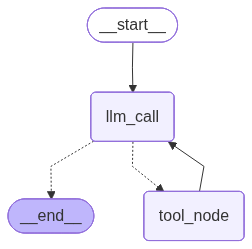


✓ Agent visualization displayed!

Key features to notice:
  - Conditional edge from llm_call
  - Loop from tool_node back to llm_call
  - Two possible endpoints: tool_node or END


In [27]:
try:
    # Use xray=True to see internal structure
    display(Image(agent.get_graph(xray=True).draw_mermaid_png()))
    print("\n✓ Agent visualization displayed!")
    print("\nKey features to notice:")
    print("  - Conditional edge from llm_call")
    print("  - Loop from tool_node back to llm_call")
    print("  - Two possible endpoints: tool_node or END")
except Exception as e:
    print(f"Could not display visualization: {e}")

## Step 9: Test the Agent

Let's test our agent with a mathematical problem!

In [28]:
from langchain_core.messages import HumanMessage

# Create a test message
messages = [HumanMessage(content="Add 3 and 4.")]

print("Testing agent with: 'Add 3 and 4.'\n")
print("=" * 50)

# Invoke the agent
result = agent.invoke({"messages": messages, "llm_calls": 0})

print("\n" + "=" * 50)
print("\nFull conversation:")
print("=" * 50)

# Display all messages
for m in result["messages"]:
    m.pretty_print()

print("=" * 50)
print(f"\nTotal LLM calls: {result['llm_calls']}")

Testing agent with: 'Add 3 and 4.'



Full conversation:
================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

[{'text': "I'll help you add 3 and 4 using the add function.", 'type': 'text'}, {'id': 'toolu_015uwtEPz647UtCSkL6PGVVc', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_015uwtEPz647UtCSkL6PGVVc)
 Call ID: toolu_015uwtEPz647UtCSkL6PGVVc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.

Total LLM calls: 2


## Step 10: Test with Complex Operations

Let's try a more complex problem that requires multiple tool calls!

In [ ]:
# Test with a complex operation
messages = [HumanMessage(content="Multiply 3 and 4, then add 10 to the result.")]

print("Testing with: 'Multiply 3 and 4, then add 10 to the result.'\n")
print("=" * 50)

result = agent.invoke({"messages": messages, "llm_calls": 0})

print("\n" + "=" * 50)
print("\nFull conversation:")
print("=" * 50)

for m in result["messages"]:
    m.pretty_print()

print("=" * 50)
print(f"\nTotal LLM calls: {result['llm_calls']}")
print("\nNote: The agent might need multiple LLM calls to:")
print("  1. First call: Decide to multiply 3 and 4")
print("  2. Second call: Use the result (12) to add 10")
print("  3. Third call: Provide the final answer to the user")

## Interactive Calculator Agent

Now let's create an interactive session with our calculator agent!

In [ ]:
print("=" * 50)
print("Interactive Calculator Agent - Chapter 3")
print("=" * 50)
print("This agent can perform arithmetic operations!")
print("Try asking it to add, multiply, or divide numbers.")
print("Type 'quit', 'exit', or 'q' to exit\n")

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        # Invoke the agent
        messages = [HumanMessage(content=user_input)]
        result = agent.invoke({"messages": messages, "llm_calls": 0})

        # Display only the final response
        final_message = result["messages"][-1]
        print(f"\nAssistant: {final_message.content}")
        print(f"(Used {result['llm_calls']} LLM calls)\n")

    except KeyboardInterrupt:
        print("\nGoodbye!")
        break
    except Exception as e:
        print(f"An error occurred: {e}")
        break

## Chapter 3 Summary

Congratulations! You've built a sophisticated AI agent with advanced capabilities! 🎉

### What You Learned:

1. **Custom Tools**: How to create tools with the `@tool` decorator
2. **Advanced State**: How to track multiple state keys
3. **Custom Tool Nodes**: How tool execution works under the hood
4. **State Tracking**: How to monitor agent behavior (LLM calls)
5. **Complex Workflows**: How agents can loop and make multiple decisions

### Key Concepts:

- **Custom Tools**: Define domain-specific operations
- **Extended State**: Track multiple pieces of information
- **Manual Tool Execution**: Full control over tool calling
- **State Monitoring**: Track and optimize agent behavior
- **Iterative Problem Solving**: Agents can use tools multiple times

### Differences from Chapter 2:

| Aspect | Chapter 2 | Chapter 3 |
|--------|-----------|----------|
| Tools | Prebuilt (Tavily) | Custom (@tool) |
| State | Messages only | Messages + counter |
| Tool Node | Prebuilt ToolNode | Custom implementation |
| Routing | Prebuilt tools_condition | Custom should_continue |
| Purpose | Web search | Arithmetic operations |

### What You Can Build Now:

With these skills, you can create:
- **Research Agents**: Agents that search and synthesize information
- **Data Processing Agents**: Agents that manipulate and analyze data
- **Workflow Automation**: Agents that orchestrate complex processes
- **Interactive Assistants**: Conversational agents with specialized skills
- **Multi-Tool Agents**: Agents that combine multiple capabilities

### Next Steps:

To continue your LangGraph journey:

1. **Add Memory**: Make agents remember across sessions
2. **Human-in-the-Loop**: Add approval workflows
3. **Parallel Execution**: Run multiple tools simultaneously
4. **Error Handling**: Make agents robust to failures
5. **Multi-Agent Systems**: Coordinate multiple specialized agents

### Resources:

- 📚 [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- 🎓 [LangGraph Tutorials](https://langchain-ai.github.io/langgraph/tutorials/)
- 💬 [LangChain Discord](https://discord.gg/langchain)
- 📺 [YouTube Tutorials](https://www.youtube.com/@LangChain)

Thank you for completing this comprehensive tutorial! 🚀

Happy building! 🎉

---
## Appendix: Complete Code Snippets

Here are complete, runnable code snippets for each chapter that you can copy and use:

### Chapter 1: Basic Chatbot (Complete Code)

In [ ]:
# Complete Chapter 1 code
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# LLM
llm = init_chat_model("openai:gpt-4o", temperature=0)

# Graph
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

# Use it
# result = graph.invoke({"messages": [{"role": "user", "content": "Hello!"}]})
# print(result["messages"][-1].content)

### Chapter 2: Chatbot with Tools (Complete Code)

In [ ]:
# Complete Chapter 2 code
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch

# State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Tools
tool = TavilySearch(max_results=2)
tools = [tool]

# LLM with tools
llm = init_chat_model("openai:gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# Graph
graph_builder = StateGraph(State)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

# Use it
# result = graph.invoke({"messages": [{"role": "user", "content": "What's new in AI?"}]})
# print(result["messages"][-1].content)

### Chapter 3: Advanced Agent (Complete Code)

In [ ]:
# Complete Chapter 3 code
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, SystemMessage, ToolMessage
from langchain.chat_models import init_chat_model
import operator

# Tools
@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """Divide a by b."""
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}

# LLM
llm = init_chat_model("anthropic:claude-3-7-sonnet-latest", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# State
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

# Nodes
def llm_call(state: dict):
    return {
        "messages": [
            llm_with_tools.invoke(
                [SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

def tool_node(state: dict):
    if messages := state.get("messages", []):
        message = messages[-1]
    else:
        raise ValueError("No message found in input")

    outputs = []
    for tool_call in message.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=str(observation),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tool_node"
    return END

# Graph
agent_builder = StateGraph(MessagesState)
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, ["tool_node", END])
agent_builder.add_edge("tool_node", "llm_call")

agent = agent_builder.compile()

# Use it
# from langchain_core.messages import HumanMessage
# result = agent.invoke({"messages": [HumanMessage(content="Add 3 and 4.")], "llm_calls": 0})
# print(result["messages"][-1].content)
# print(f"LLM calls: {result['llm_calls']}")